# Report01-价格预测
+ 姓名：何文韬
+ 学号：2021300234


## 任务简介


   市场房价预测模型的建立对于房地产市场的参与者具有重要意义。通过对多个影响因素进行深入分析和建模，我们将寻找与房价密切相关的因素，从而实现对未来房价走势的准确预测。回归模型适用于分析受多个因素影响的数据，并通过多个自变量的最优组合来预测或估计因变量，相比只使用一个自变量进行预测或估计更有效，更贴近实际情况。
   
   本次报告使用了包含12个与房价相关的信息的数据集，其中包括16573条训练数据和7104条测试数据。报告的目标是找到一个合适的回归模型，并以较小的均方根误差作为评判标准。
## 解决途径


   本报告首先对数据进行了预处理，获取了数据集的相关信息。随后，采用标签编码的方式将分类类型转换为连续的数值变量，以提高模型的速度和准确率。最后，选择了多元线性回归模型和随机森林回归模型，并采用K折交叉验证的方法计算均方根误差。选择多元线性回归模型的原因有：
   1. 在多元线性回归分析是多元回归分析中最基础、最简单的一种。
   2. 运用回归模型，只要采用的模型和数据相同，通过标准的统计方法可以计算出唯一的结果。
   
   选择随机森林回归模型的原因有：
   1. 高准确性：随机森林回归通过组合多个决策树的预测结果，可以获得较高的回归准确性。
   2. 可解释性：随机森林回归可以提供每个特征的重要性评估，帮助理解回归模型的影响因素。
   3. 能够处理高维数据：随机森林回归对于高维数据具有较好的适应性，可以处理大量特征。

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [62]:
#读取数据集
train = pd.read_csv("train_data.csv")
test = pd.read_csv("test_data.csv")

## 分析数据

In [63]:
train.shape

(16573, 12)

In [64]:
test.shape

(7104, 12)

In [65]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16573 entries, 0 to 16572
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Direction   16573 non-null  object 
 1   District    16573 non-null  object 
 2   Elevator    10833 non-null  object 
 3   Floor       16573 non-null  int64  
 4   Garden      16573 non-null  object 
 5   Id          16573 non-null  int64  
 6   Layout      16573 non-null  object 
 7   Price       16573 non-null  float64
 8   Region      16573 non-null  object 
 9   Renovation  16573 non-null  object 
 10  Size        16573 non-null  float64
 11  Year        16573 non-null  int64  
dtypes: float64(2), int64(3), object(7)
memory usage: 1.5+ MB


In [66]:
train.describe()#数据描述

Floor            Id         Price          Size          Year
count  16573.000000  1.657300e+04  16573.000000  16573.000000  16573.000000
mean      12.824474  1.011024e+11    609.102094     98.955108   2001.370482
std        7.672493  5.744563e+05    410.795539     50.497967      9.003195
min        1.000000  1.010886e+11     60.000000      2.000000   1950.000000
25%        6.000000  1.011022e+11    360.000000     66.000000   1997.000000
50%       11.000000  1.011025e+11    497.000000     88.000000   2003.000000
75%       18.000000  1.011027e+11    710.000000    118.000000   2008.000000
max       57.000000  1.011028e+11   6000.000000   1019.000000   2017.000000

In [67]:
train.isnull().sum().sort_values(ascending=False) # 统计每一列NaN的数量，将结果按照降序排序

Elevator      5740
Direction        0
District         0
Floor            0
Garden           0
Id               0
Layout           0
Price            0
Region           0
Renovation       0
Size             0
Year             0
dtype: int64

根据结果发现，只有电梯那列出现NaN（未定义的数值）

In [68]:
train.isnull().sum().sort_values(ascending=False) / train.shape[0]## 计算NaN的占比，将结果按照降序排序

Elevator      0.346346
Direction     0.000000
District      0.000000
Floor         0.000000
Garden        0.000000
Id            0.000000
Layout        0.000000
Price         0.000000
Region        0.000000
Renovation    0.000000
Size          0.000000
Year          0.000000
dtype: float64

发现电梯那列NaN的占比达到35%，影响并不大，选择保留电梯列

In [69]:
# 统计train,test所有列中的：数值类型的列 和 分类类型的列
number_columns = [ col for col in train.columns if train[col].dtype != 'object']

category_columns = [col for col in train.columns if train[col].dtype == 'object']

In [70]:
len(number_columns)

5

In [71]:
len(category_columns)

7

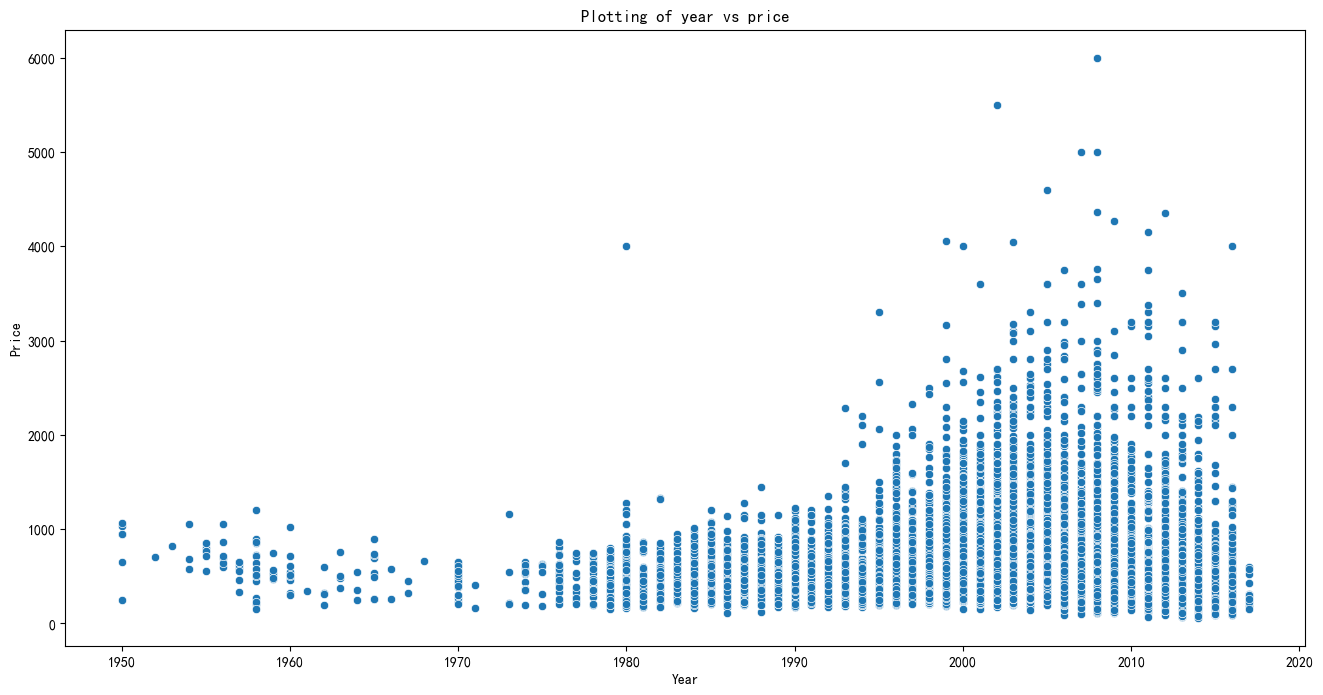

In [72]:
#画出年份与价格的关系图
plt.figure(figsize=(16, 8)) # 画布大小
plt.title("Plotting of year vs price")  # 画布标题
sns.scatterplot(x="Year", y="Price", data=train) 
plt.show()

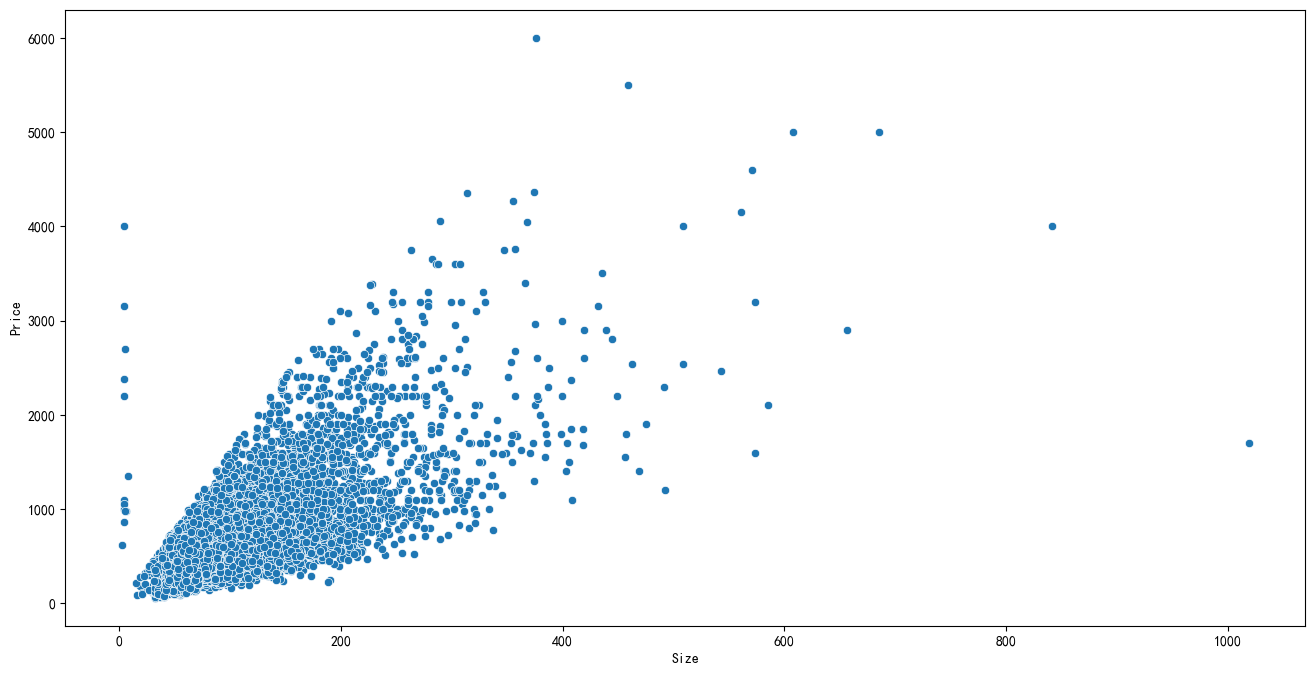

In [73]:
#画出楼层面积与价格的关系图
plt.figure(figsize=(16, 8))
sns.scatterplot(x=train["Size"], y=train["Price"])
plt.show()

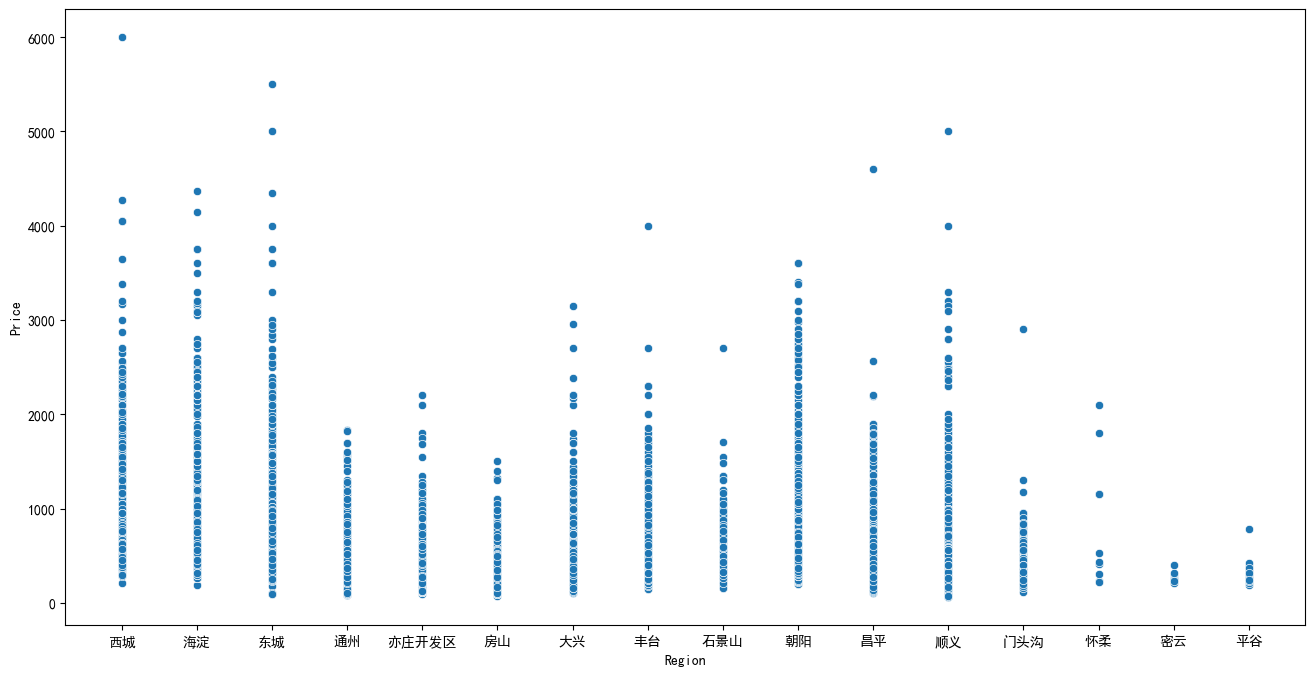

In [74]:
#画出地域与价格的关系图
plt.figure(figsize=(16, 8))
sns.scatterplot(x="Region", y="Price", data=train)
plt.rcParams['font.sans-serif'] = ['SimHei']#显示中文标签
plt.show()

数据集分类

In [37]:
# 对 分类类型 列进行LabelEncoding
# 举例：A, B, C, D, E  --LabelEncoding--> 0, 1, 2, 3, 4
# 将分类类型变成连续的数值变量，有利于模型的预测和提高准确率
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()

for col in category_columns:
    train[col] = LE.fit_transform(train[col])
    test[col] = LE.fit_transform(test[col])

In [38]:
# 构建训练集和验证集
X = train.drop(columns=['Id', 'Price'], axis=1).values # 说明：Id不是特征，Price是标签，需要屏蔽
y = train['Price'].values # 标签 Price

In [39]:
#3.数据集分离
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True) # 验证集占比30%，打乱顺序


## 创建回归模型

### 方案一：线性回归+K折交叉验证

In [41]:
# 1线性回归
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
'''
MSE: Mean Squared Error
均方误差是指参数估计值与参数真值之差平方的期望值;
MSE可以评价数据的变化程度，MSE的值越小，说明预测模型描述实验数据具有更好的精确度。

'''
#K折交叉验证
kf = KFold(n_splits=10) # 10折

rmse_scores = [] # 保存10折运行的结果


for train_indices, test_indices in kf.split(X): # 分割元数据，生成索引列表
    X_train, X_test = X[train_indices], X[test_indices] # 训练集和验证集
    y_train, y_test = y[train_indices], y[test_indices] # 训练标签集和验证标签集
    # 初始化线性回归模型对象
    LR = LinearRegression()
    LR.fit(X_train, y_train) # 训练
    y_pred = LR.predict(X_test) # 预测
    rmse = np.sqrt(mean_absolute_error(np.log(y_test), np.log(abs(y_pred)))) # 评估
    rmse_scores.append(rmse) # 累计每一轮的验证结果
   

print("均方根误差: ", rmse_scores)
print(f'平均均方根误差: {np.mean(rmse_scores)}')

均方根误差:  [0.5593036106922968, 0.5480450927554439, 0.5570330548134637, 0.5507974550422999, 0.556288357846846, 0.5584638766251072, 0.5626733285211468, 0.5538055352322054, 0.5661051705650811, 0.551058883063862]
平均均方根误差: 0.5563574365157754


### 方案二：随机森林+K折交叉验证

In [42]:
# 2 随机森林（回归）
from sklearn.ensemble import RandomForestRegressor

# K折交叉验证
kf = KFold(n_splits=10)

rmse_scores = [] 

for train_indices, test_indices in kf.split(X):
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]
    # 初始化模型
    RFR = RandomForestRegressor() # 基模型
    # 训练/fit拟合
    RFR.fit(X_train, y_train)
    # 预测
    y_pred = RFR.predict(X_test)
    # 评估
    rmse = mean_absolute_error(y_test, y_pred)
    # 累计结果
    rmse_scores.append(rmse)

print("均方根误差: ", rmse_scores)
print(f'平均均方根误差: {np.mean(rmse_scores)}')


均方根误差:  [66.61209048415397, 69.18503016377805, 72.83173646533402, 66.03249276039124, 66.4616300403144, 68.61086452615646, 65.99913167322853, 68.83428070993581, 74.5044919851154, 72.0002111843933]
平均均方根误差: 69.10719599928011


## 总结
在做完这个项目上之后，我明白了在特定数据集要使用合适的模型去求解，不能万能地套用某一个模型评价一个模型的好坏有很多种指标，本项目选择了均方根误差，是预测模型比较重要的一项指标。多元线性回归模型的均方根误差在0.55左右远小于2，所以该模型的效果还是不错的。
在完成报告地过程中也遇到了很多问题，比如绘图中各参数的使用，最后都通过网络查询解决。